<a href="https://colab.research.google.com/github/Moshakamrai/Face_Recognition/blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.5.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.2
astunparse                       1.6.3
async-timeout                    4.0.3
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0


In [3]:
import tensorflow as tf
import os

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
!git clone https://github.com/kazisohrabuddintitu/Face_Recognition_System.git


Cloning into 'Face_Recognition_System'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 233 (delta 3), reused 0 (delta 0), pack-reused 225
Receiving objects: 100% (233/233), 488.93 MiB | 7.03 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (212/212), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [13]:
input_directory = '/content/Face_Recognition_System/face_recognition/input_directory'
model_directory = '/content/Face_Recognition_System/face_recognition/model_directory'
test_directory = '/content/Face_Recognition_System/face_recognition/test_directory'

In [14]:
def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)

  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")

  plt.title("Image: " + repr(path.split("/")[-2]))

In [15]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(input_directory, topdown=False):
  # print(f"root: {root}  dirs: {dirs}   files: {files}")
  # print("-"*10)
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("jpg") or path.endswith("png") or path.endswith("JPG") or path.endswith("PNG"): # We want only the images
      imagepaths.append(path)

class_list = dirs
print("Unique face list: ",class_list)
print("Total images: ",len(imagepaths)) # If > 0, then a PNG and JPG image was loaded


Unique face list:  ['alal', 'alvi', 'asif', 'sohrab']
Total images:  200


In [16]:
for i in range(10):
  if(len(imagepaths) > i):
    print(imagepaths[i])

/content/Face_Recognition_System/face_recognition/input_directory/alal/IMG_3080.JPG
/content/Face_Recognition_System/face_recognition/input_directory/alal/IMG_3038.JPG
/content/Face_Recognition_System/face_recognition/input_directory/alal/IMG_3088.JPG
/content/Face_Recognition_System/face_recognition/input_directory/alal/IMG_3048.JPG
/content/Face_Recognition_System/face_recognition/input_directory/alal/IMG_3040.JPG
/content/Face_Recognition_System/face_recognition/input_directory/alal/IMG_3067.JPG
/content/Face_Recognition_System/face_recognition/input_directory/alal/IMG_3084.JPG
/content/Face_Recognition_System/face_recognition/input_directory/alal/IMG_3047.JPG
/content/Face_Recognition_System/face_recognition/input_directory/alal/IMG_3042.JPG
/content/Face_Recognition_System/face_recognition/input_directory/alal/IMG_3065.JPG


In [17]:
# This function is used more for debugging and showing results later. It plots the image into the notebook
def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)

  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")

  plt.title("Image: " + path.split("/")[-2])

Image of:  sohrab


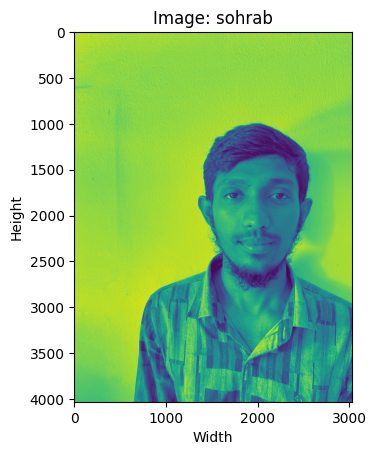

In [18]:
random_img_path = imagepaths[random.randrange(0,len(imagepaths))]
print("Image of: ",random_img_path.split("/")[-2])
plot_image(random_img_path) #We plot the first image from our imagepaths array

In [ ]:
image_list = [] # Image data
label_list = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:

  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  image_list.append(img)

  # Processing label in image path
  category = path.split("/")[-2]
  label = int(class_list.index(category)) # We need to convert 10_down to 00_down, or else it crashes
  label_list.append(label)

# Turn X and y into np.array to speed up train_test_split
image_list = np.array(image_list, dtype="uint8")
image_list = image_list.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
label_list = np.array(label_list)

print("Images loaded: ", len(image_list))
print("Labels loaded: ", len(label_list))

print("Unique face list: ",class_list)
# print("5 random images with coresponding Label: ")
# for i in range(5):
#   r = random.randrange(0,len(label_list))
#   print(f"Label: {label_list[r]}      Path: {imagepaths[r]}")
print("All images with coresponding Label: ")
for i in range(len(label_list)):
  print(f"Label: {label_list[i]}      Path: {imagepaths[i]}")

In [20]:
#tr = 0.1 # Percentage of images that we want to use for training.
ts = 0.2 # Percentage of images that we want to use for testing.
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=ts, random_state=42)

In [21]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))


160
40
160
40


In [22]:
def get_model():
  model = Sequential()
  model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(len(label_list), activation='softmax'))

  return model

In [23]:
model = get_model()

model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [24]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(x_train, y_train, epochs=15, batch_size=25, verbose=2, validation_data=(x_test, y_test))

Epoch 1/15
7/7 - 17s - loss: 40.4109 - accuracy: 0.1688 - val_loss: 0.8057 - val_accuracy: 0.7500 - 17s/epoch - 2s/step
Epoch 2/15
7/7 - 22s - loss: 0.6786 - accuracy: 0.7688 - val_loss: 0.4492 - val_accuracy: 0.8500 - 22s/epoch - 3s/step
Epoch 3/15
7/7 - 15s - loss: 0.1566 - accuracy: 0.9438 - val_loss: 0.0659 - val_accuracy: 0.9750 - 15s/epoch - 2s/step
Epoch 4/15
7/7 - 14s - loss: 0.0225 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 1.0000 - 14s/epoch - 2s/step
Epoch 5/15
7/7 - 14s - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 1.0000 - 14s/epoch - 2s/step
Epoch 6/15
7/7 - 14s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0816 - val_accuracy: 0.9500 - 14s/epoch - 2s/step
Epoch 7/15
7/7 - 14s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 1.0000 - 14s/epoch - 2s/step
Epoch 8/15
7/7 - 14s - loss: 2.4031e-04 - accuracy: 1.0000 - val_loss: 0.0328 - val_accuracy: 1.0000 - 14s/epoch - 2s/step
Epoch 9/15
7/7 - 14s - loss: 0.0012 - accur

In [25]:
# Save entire model to a HDF5 file
name = 'facerecognition_model.h5'

model_path = os.path.join(model_directory, name)

print(model_path)

/content/Face_Recognition_System/face_recognition/model_directory/facerecognition_model.h5


In [26]:
model.save(model_path)

In [27]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

2/2 [==============================] - 1s 142ms/step - loss: 0.0024 - accuracy: 1.0000
Test accuracy: 100.00%


In [30]:
#import the model
from tensorflow import keras
name = 'facerecognition_model.h5'
model_path = os.path.join(model_directory, name)
model = keras.models.load_model(model_path, compile=False)

In [31]:
predictions = model.predict(x_test) # Make predictions towards the test set

2/2 [==============================] - 1s 254ms/step


In [32]:
cnt_true = 0
cnt_false = 0
for i in range(len(predictions)):

  # print(np.argmax(predictions[i]), y_test[i]) # If same, got it right

  if np.argmax(predictions[i]) == y_test[i]:
    cnt_true+=1

  else:
    cnt_false+=1

print('Number of Accurate predicted images: {0}'.format(cnt_true))

print('Number of Wrong predicted images: {0}'.format(cnt_false))

Number of Accurate predicted images: 40
Number of Wrong predicted images: 0


In [33]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array, class_names):

  plt.figure(figsize=(15,5))

  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction

    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(predicted_label,
                                  100*np.max(prediction),
                                  true_label),
                                  color=color)
  plt.show()

Class names with corresponding person name: 
{0: 'alal', 1: 'alvi', 2: 'asif', 3: 'sohrab'}


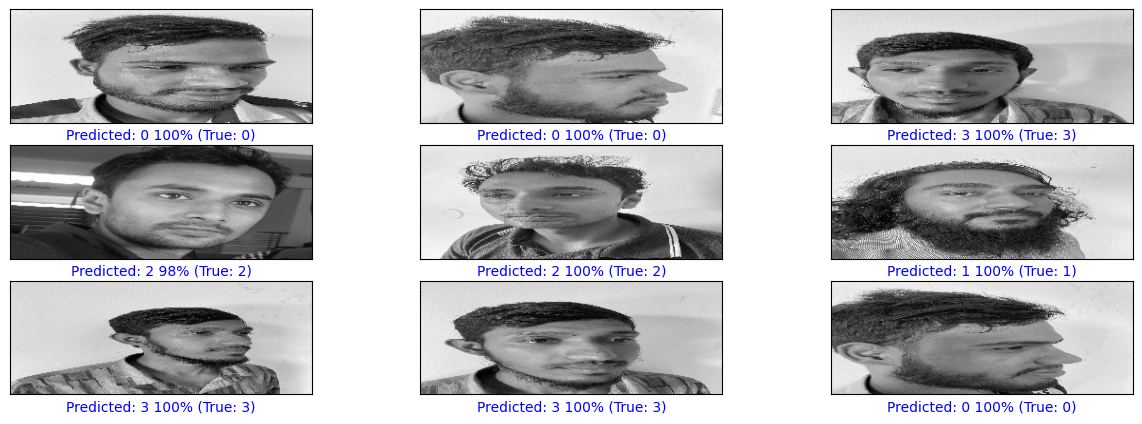

In [34]:
class_dict = {}
for i in range(len(class_list)):
  class_dict[i] = class_list[i]

print("Class names with corresponding person name: ")
print(class_dict)

validate_9_images(predictions, y_test, x_test, class_dict)

In [35]:
# creating a list of image file names
image_input_list = sorted(os.listdir(test_directory))
print(image_input_list)

['alvi.jpg', 'asif.jpg', 'sohrab.JPEG', 'sohrab2.jpg']


In [36]:
X = [] # Image data

# Loops through imagepaths to load images and labels into arrays
for path in image_input_list:
  img = os.path.join(test_directory, path)
  print(img)
  img = cv2.imread(img) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)

# Turn X into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(image_input_list), 120, 320, 1) # Needed to reshape so CNN knows it's different images

print("Images loaded: ", len(X))

/content/Face_Recognition_System/face_recognition/test_directory/alvi.jpg
/content/Face_Recognition_System/face_recognition/test_directory/asif.jpg
/content/Face_Recognition_System/face_recognition/test_directory/sohrab.JPEG
/content/Face_Recognition_System/face_recognition/test_directory/sohrab2.jpg
Images loaded:  4


In [37]:

input_predictions = model.predict(X) # Make predictions towards the test set

1/1 [==============================] - 0s 333ms/step


In [38]:
#getting the predictions in a list as int
index_of_char = []
for i in range(len(input_predictions)):
  index_of_char.append(int(np.argmax(input_predictions[i])))

In [39]:
print(index_of_char)

[1, 2, 3, 3]


In [40]:
for i in index_of_char:
  print("The predicted face is: {0}".format(class_dict[i]))

The predicted face is: alvi
The predicted face is: asif
The predicted face is: sohrab
The predicted face is: sohrab
